In [1]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
    
# tf.config.experimental.set_visible_devices([], 'GPU')
# tf.debugging.set_log_device_placement(True)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2022-10-17 00:28:48.644654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 00:28:48.698679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 00:28:48.699554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [3]:
%%capture
prefix = 'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/weather/jobs/transform_batch/20220925-014051_e32aa567fa482e970513332d1d24fd51'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

In [4]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 826464 entries, ('Albuquerque/1108/0', Timestamp('2015-02-16 09:00:00')) to ('Vancouver/806/12', Timestamp('2014-07-03 04:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  826464 non-null  float64
 1   humidity     826464 non-null  float64
 2   pressure     826464 non-null  float64
 3   wind_speed   826464 non-null  float64
dtypes: float64(4)
memory usage: 31.9+ MB


In [5]:
score_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57576 entries, ('Albuquerque/2249/0', Timestamp('2017-07-15 13:00:00')) to ('Vancouver/2623/10', Timestamp('2017-07-07 20:00:00'))
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  57576 non-null  float64
 1   humidity     57576 non-null  float64
 2   pressure     57576 non-null  float64
 3   wind_speed   57576 non-null  float64
dtypes: float64(4)
memory usage: 2.1+ MB


In [6]:
train_X.groupby('sample').size().head()

sample
Albuquerque/1108/0    24
Albuquerque/1108/1    24
Albuquerque/1108/2    24
Albuquerque/1112/0    24
Albuquerque/1112/1    24
dtype: int64

In [7]:
train_X.loc['Albuquerque/1112/1'].head()

,temperature,humidity,pressure,wind_speed
time,,,,
2015-02-20 18:00:00,282.116500,46.0,1023.0,3.0
2015-02-20 19:00:00,287.061667,40.0,1021.0,4.0
2015-02-20 20:00:00,288.236333,38.0,1019.0,4.0
2015-02-20 21:00:00,286.928000,35.0,1020.0,4.0
2015-02-20 22:00:00,288.930333,34.0,1017.0,5.0


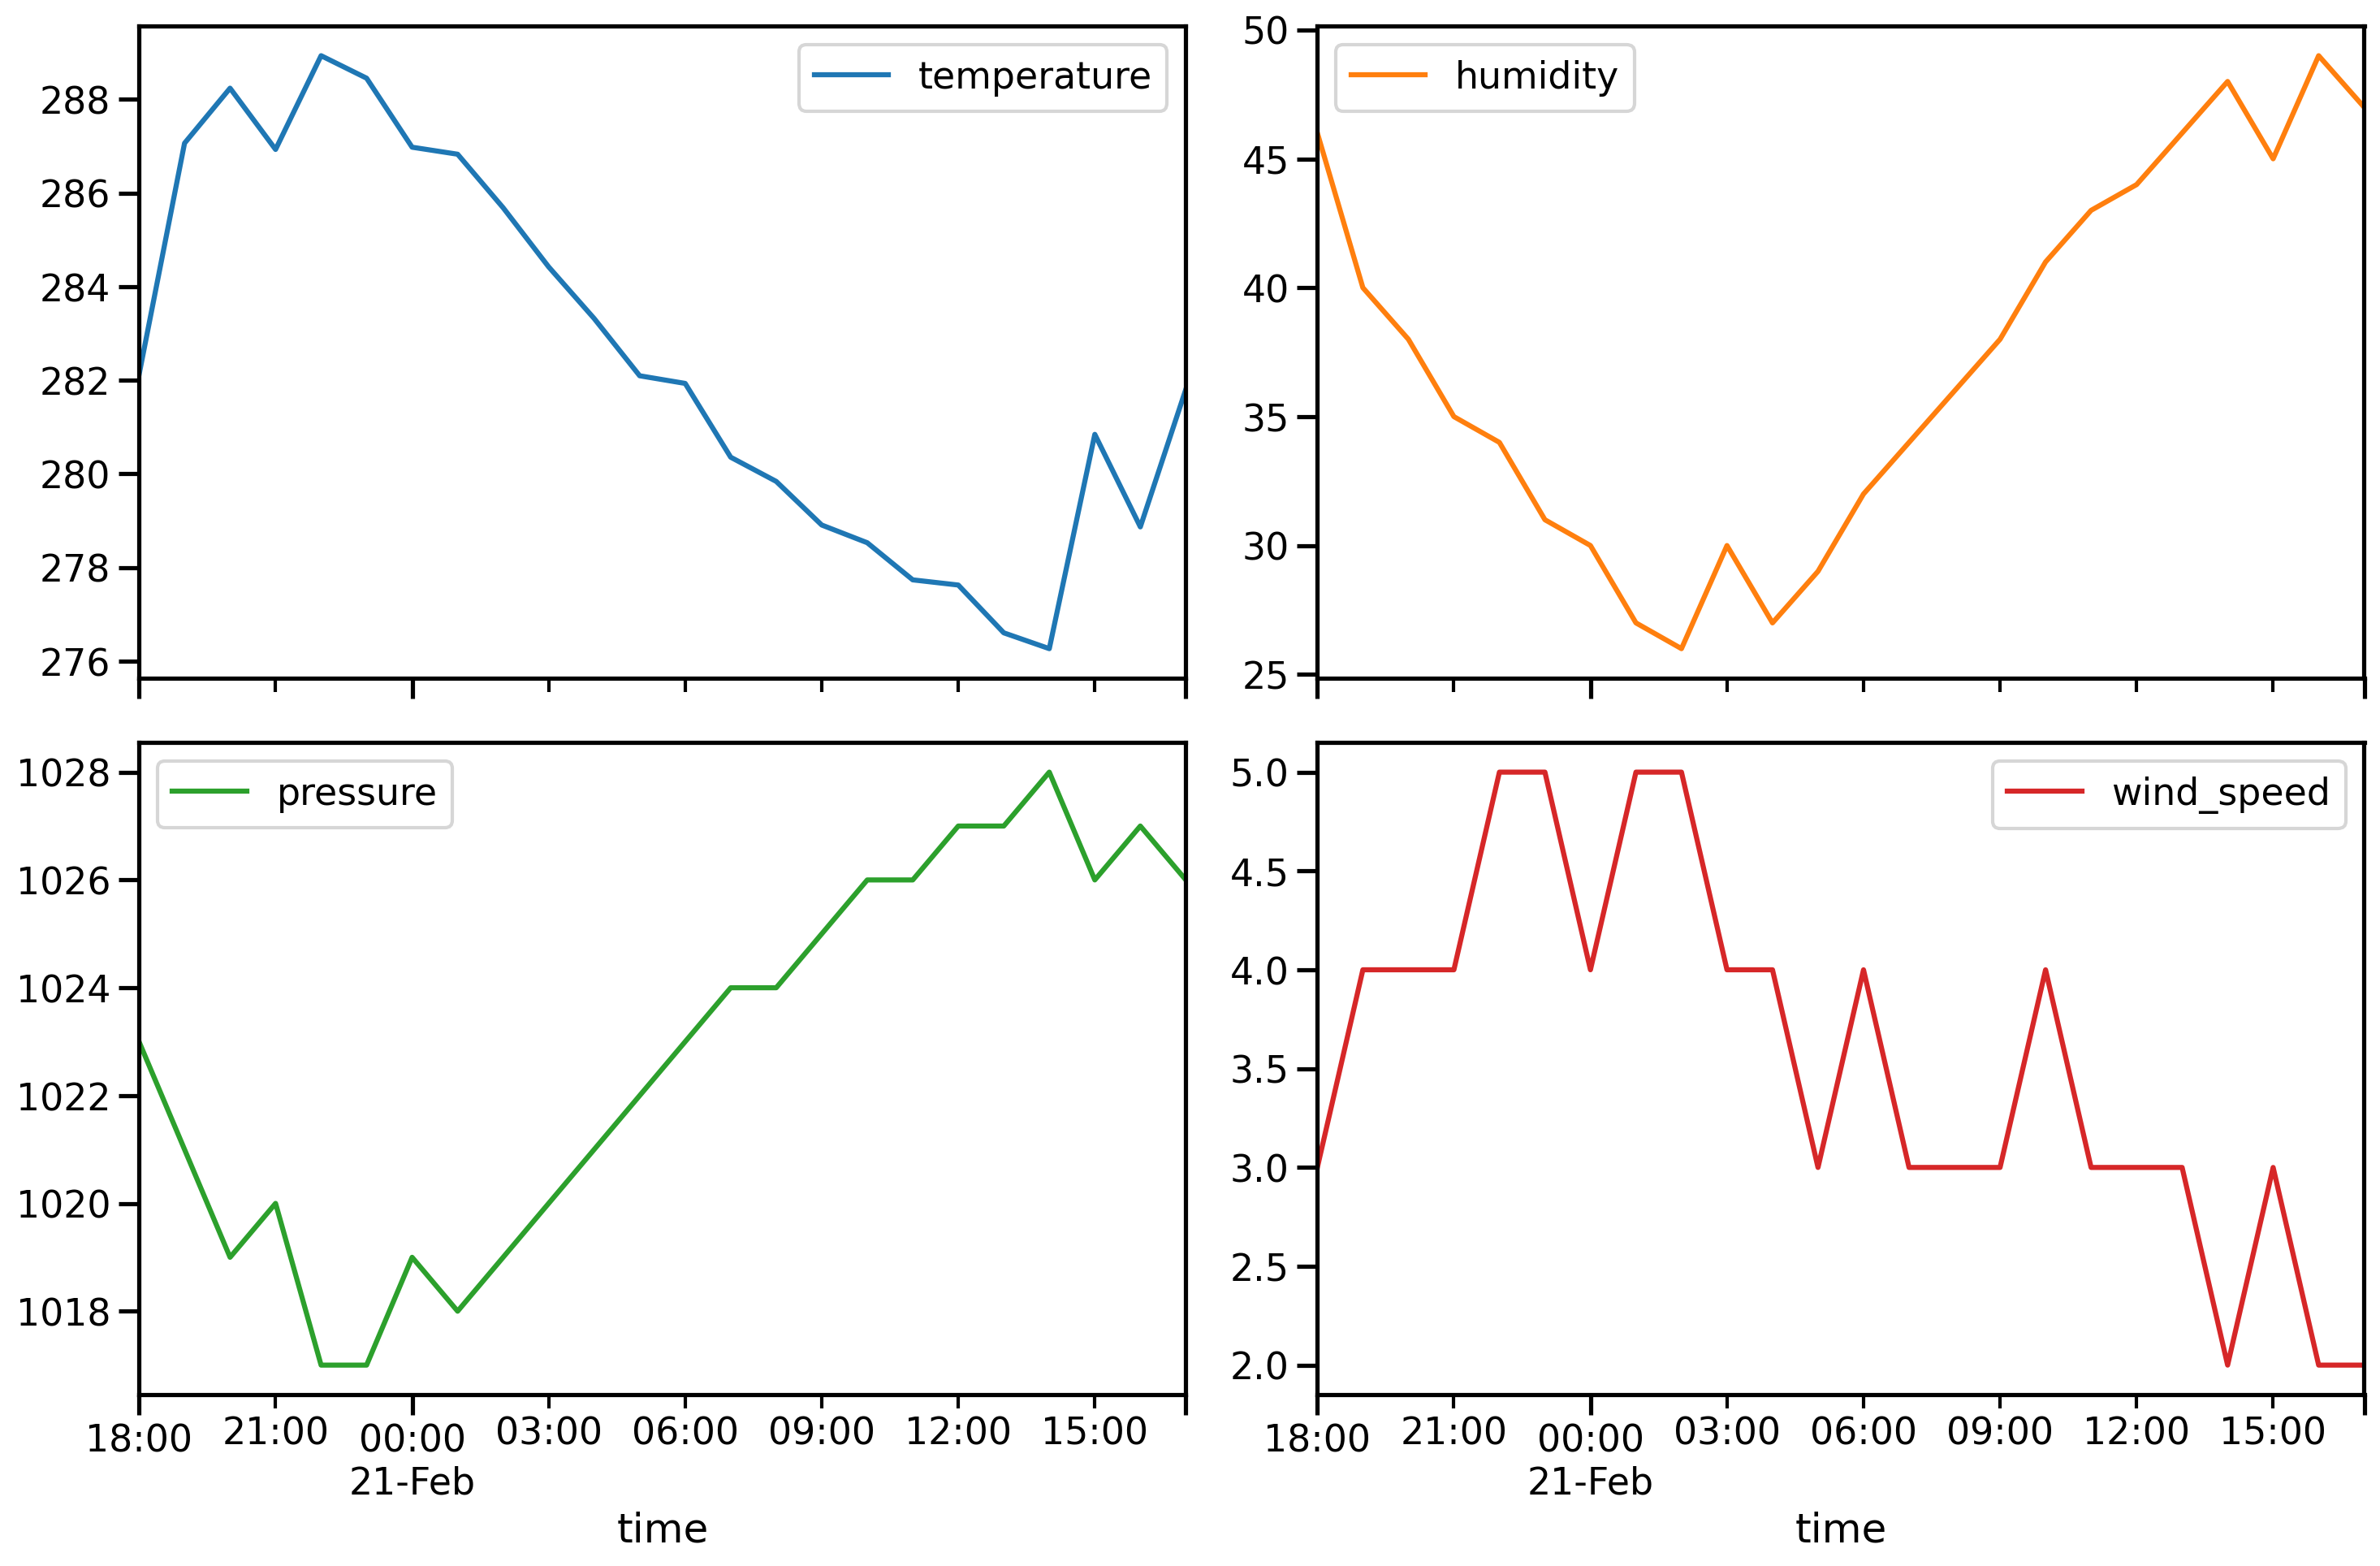

In [8]:
train_X.loc['Albuquerque/1112/1'].plot(subplots=True, layout=(2, 2), figsize=[15, 10])
plt.tight_layout()

In [9]:
### Creating dummy variables for part of the day (12 am, 6am, 12 pm, 6 pm)
#dropping the first one because of multicollinearity

In [10]:
train_X = train_X.reset_index()
train_X["hour"] = train_X["time"].dt.hour//6
train_X = pd.get_dummies(train_X, columns = ["hour"], drop_first = True)
train_X = train_X.set_index(["sample", "time"]).sort_index(axis = 1)

In [11]:
validate_X = validate_X.reset_index()
validate_X["hour"] = validate_X["time"].dt.hour//6
validate_X = pd.get_dummies(validate_X, columns = ["hour"], drop_first = True)
validate_X = validate_X.set_index(["sample", "time"]).sort_index(axis = 1)

In [12]:
test_X = test_X.reset_index()
test_X["hour"] = test_X["time"].dt.hour//6
test_X = pd.get_dummies(test_X, columns = ["hour"], drop_first = True)
test_X = test_X.set_index(["sample", "time"]).sort_index(axis = 1)

In [13]:
score_X = score_X.reset_index()
score_X["hour"] = score_X["time"].dt.hour//6
score_X = pd.get_dummies(score_X, columns = ["hour"], drop_first = True)
score_X = score_X.set_index(["sample", "time"]).sort_index(axis = 1)

In [14]:
condition_window = 24
prediction_window = 24
features_length = 7

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

scaled_X = {
    'train': scaler.transform(train_X),
    'validate': scaler.transform(validate_X),
    'test': scaler.transform(test_X),
    'score': scaler.transform(score_X),
}

In [16]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes of the input, and the desired shapes.

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(826464, 7)","(34436, 24, 7)"
train_y,"(826464, 4)","(34436, 24)"


In [17]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

### Adding frame_y parameter to use the same function for score dataset without the y values

def frame_to_ndarray(frame_X, frame_y = None):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')

    if frame_y is not None:
        y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
        return X_nd, y_nd
    
    return X_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)

# Task: Transform other segments of the dataset (test, and score).
# Enter your code here.
test_X_nd, test_y_nd = frame_to_ndarray(scaled_X['test'], test_y)
score_X_nd = frame_to_ndarray(scaled_X['score'])

In [18]:
# Let's confirm the expected shape.

### Adding test and validate data shapes
pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
        test_X_nd.shape,
        test_y_nd.shape,
        score_X_nd.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
        expected_X_shape(test_X.shape), 
        expected_y_shape(test_y.shape),
        expected_X_shape(score_X.shape), 
    ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y', 'test_X', 'test_y', 'score_X']
)

,actual shape,expected shape
train_X,"(34436, 24, 7)","(34436, 24, 7)"
train_y,"(34436, 24)","(34436, 24)"
validate_X,"(2288, 24, 7)","(2288, 24, 7)"
validate_y,"(2288, 24)","(2288, 24)"
test_X,"(2177, 24, 7)","(2177, 24, 7)"
test_y,"(2177, 24)","(2177, 24)"
score_X,"(2399, 24, 7)","(2399, 24, 7)"


In [19]:
from tensorflow.keras.layers import GRU, Dense, BatchNormalization, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform
from kerastuner.engine.hyperparameters import HyperParameters
from utils import r2_score, mean_error
from tensorflow.keras.optimizers import Adam


def build_model(hp: HyperParameters) -> tf.keras.Model:
    
    ### Choice of starting width for GRU
    GRU_width = hp.Choice('GRU_width', values = [1024, 512, 256])
    
    ### Choice of regularization for the kernel weights
    reg = hp.Choice('reg', values = ["l1", "l2", "l1_l2"])
    
    ### Choice of regularization for the recurrent weights
    rec_reg = hp.Choice('rec_reg', values = ["l1_l2"])
    
    ### Model Architecture:
        #GRUs of decreasing and then increasing widths (symmetrical) i.e., w, w/2, w/4, w/2, w with sigmoid activation
        #Batchnormalization after each GRU
        #Final Dense Layer with linear activation
    layers = [
        GRU(
            input_shape=(condition_window, features_length),
            units=width,
            return_sequences=True,
            recurrent_activation="sigmoid",
            kernel_initializer=GlorotUniform(seed=42),
            recurrent_initializer=GlorotUniform(seed=43),
            kernel_regularizer="l1",
            recurrent_regularizer="l2",
        ),
        BatchNormalization(),
        GRU(
            units=int(width/2),
            return_sequences=True,
            recurrent_activation="sigmoid",
            kernel_initializer=GlorotUniform(seed=44),
            recurrent_initializer=GlorotUniform(seed=45),
            kernel_regularizer="l1",
            recurrent_regularizer="l2",
        ),
        BatchNormalization(),
        GRU(
            units=int(width/4),
            return_sequences=True,
            recurrent_activation="sigmoid",
            kernel_initializer=GlorotUniform(seed=46),
            recurrent_initializer=GlorotUniform(seed=47),
            kernel_regularizer="l1",
            recurrent_regularizer="l2",
        ),
        BatchNormalization(),
        GRU(
            units=int(width/2),
            return_sequences=True,
            recurrent_activation="sigmoid",
            kernel_initializer=GlorotUniform(seed=47),
            recurrent_initializer=GlorotUniform(seed=48),
            kernel_regularizer="l1",
            recurrent_regularizer="l2",
        ),
        BatchNormalization(),
        GRU(
            units=int(width),
            return_sequences=False,
            recurrent_activation="sigmoid",
            kernel_initializer=GlorotUniform(seed=49),
            recurrent_initializer=GlorotUniform(seed=50),
            kernel_regularizer="l1",
            recurrent_regularizer="l2",
        ),
        BatchNormalization(),
        Dense(
            units=prediction_window,
            kernel_initializer=GlorotUniform(seed=52),
            activation='linear',
        )
    ]
    
        
    model = Sequential(layers)

    
    ### Using Adam Optimizer
    model.compile(
        optimizer=Adam(
            lr=0.01
        ),
        loss='mean_squared_error',
        metrics=[
            'mean_absolute_error',
            r2_score,
            mean_error
        ]
    )
    
    return model

/tmp/ipykernel_19526/2797412969.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [ ]:
from kerastuner.tuners import RandomSearch

### Using Keras Tuner to try different parameters
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='rnn_hyperop',
    project_name='rnn_14'
)

tuner.search_space_summary()

In [ ]:
%%time
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

### Fitting the Model with TerminateOnNaN, ReduceLROnPlateau, EarlyStopping callbacks for 128 epochs
tuner.search(    
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=128,
    batch_size=128,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.1,
            patience=5,
            cooldown=10,
            verbose=1
        ),
        EarlyStopping(
            monitor='loss',
            min_delta=0.1,
            patience=10
        )
    ]
)

In [21]:
### Getting the best model from tuner 
model = tuner.get_best_models(num_models=1)[0]

In [23]:
# Note that Keras evaluates metrics in batches,
# which is okay for averaging-stable metrics like ME, MSE, and MAE,
# but R2 requires full dataset to evaluate precisely.

# This implies two things:
# 1) R2 as reported during training is not precise
# 2) when evaluating R2 after training, batch size must match dataset size

### Note: removed train while running the evaluation as it was getting out of memory
nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd),
    'test': (test_X_nd, test_y_nd)
}

metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'R2', 'ME'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(2)

rnn_metrics

2022-10-17 00:28:59.911638: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


validate                     test                 
         MSE   MAE    R2    ME    MSE   MAE    R2   ME
rnn     17.2  2.98  0.82  0.14  12.47  2.53  0.84 -0.5

In [24]:
from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate', 'test']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

In [25]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, (slice(None), ['MSE', 'R2'])].round(2)

,train,validate,test,train,validate,test
,MSE,MSE,MSE,R2,R2,R2
mean,26.77,37.23,NaN,0.80,0.58,NaN
constant,21.82,40.25,NaN,0.84,0.54,NaN
regression,30.53,29.94,NaN,0.78,0.66,NaN
rnn,NaN,17.20,12.47,NaN,0.82,0.84


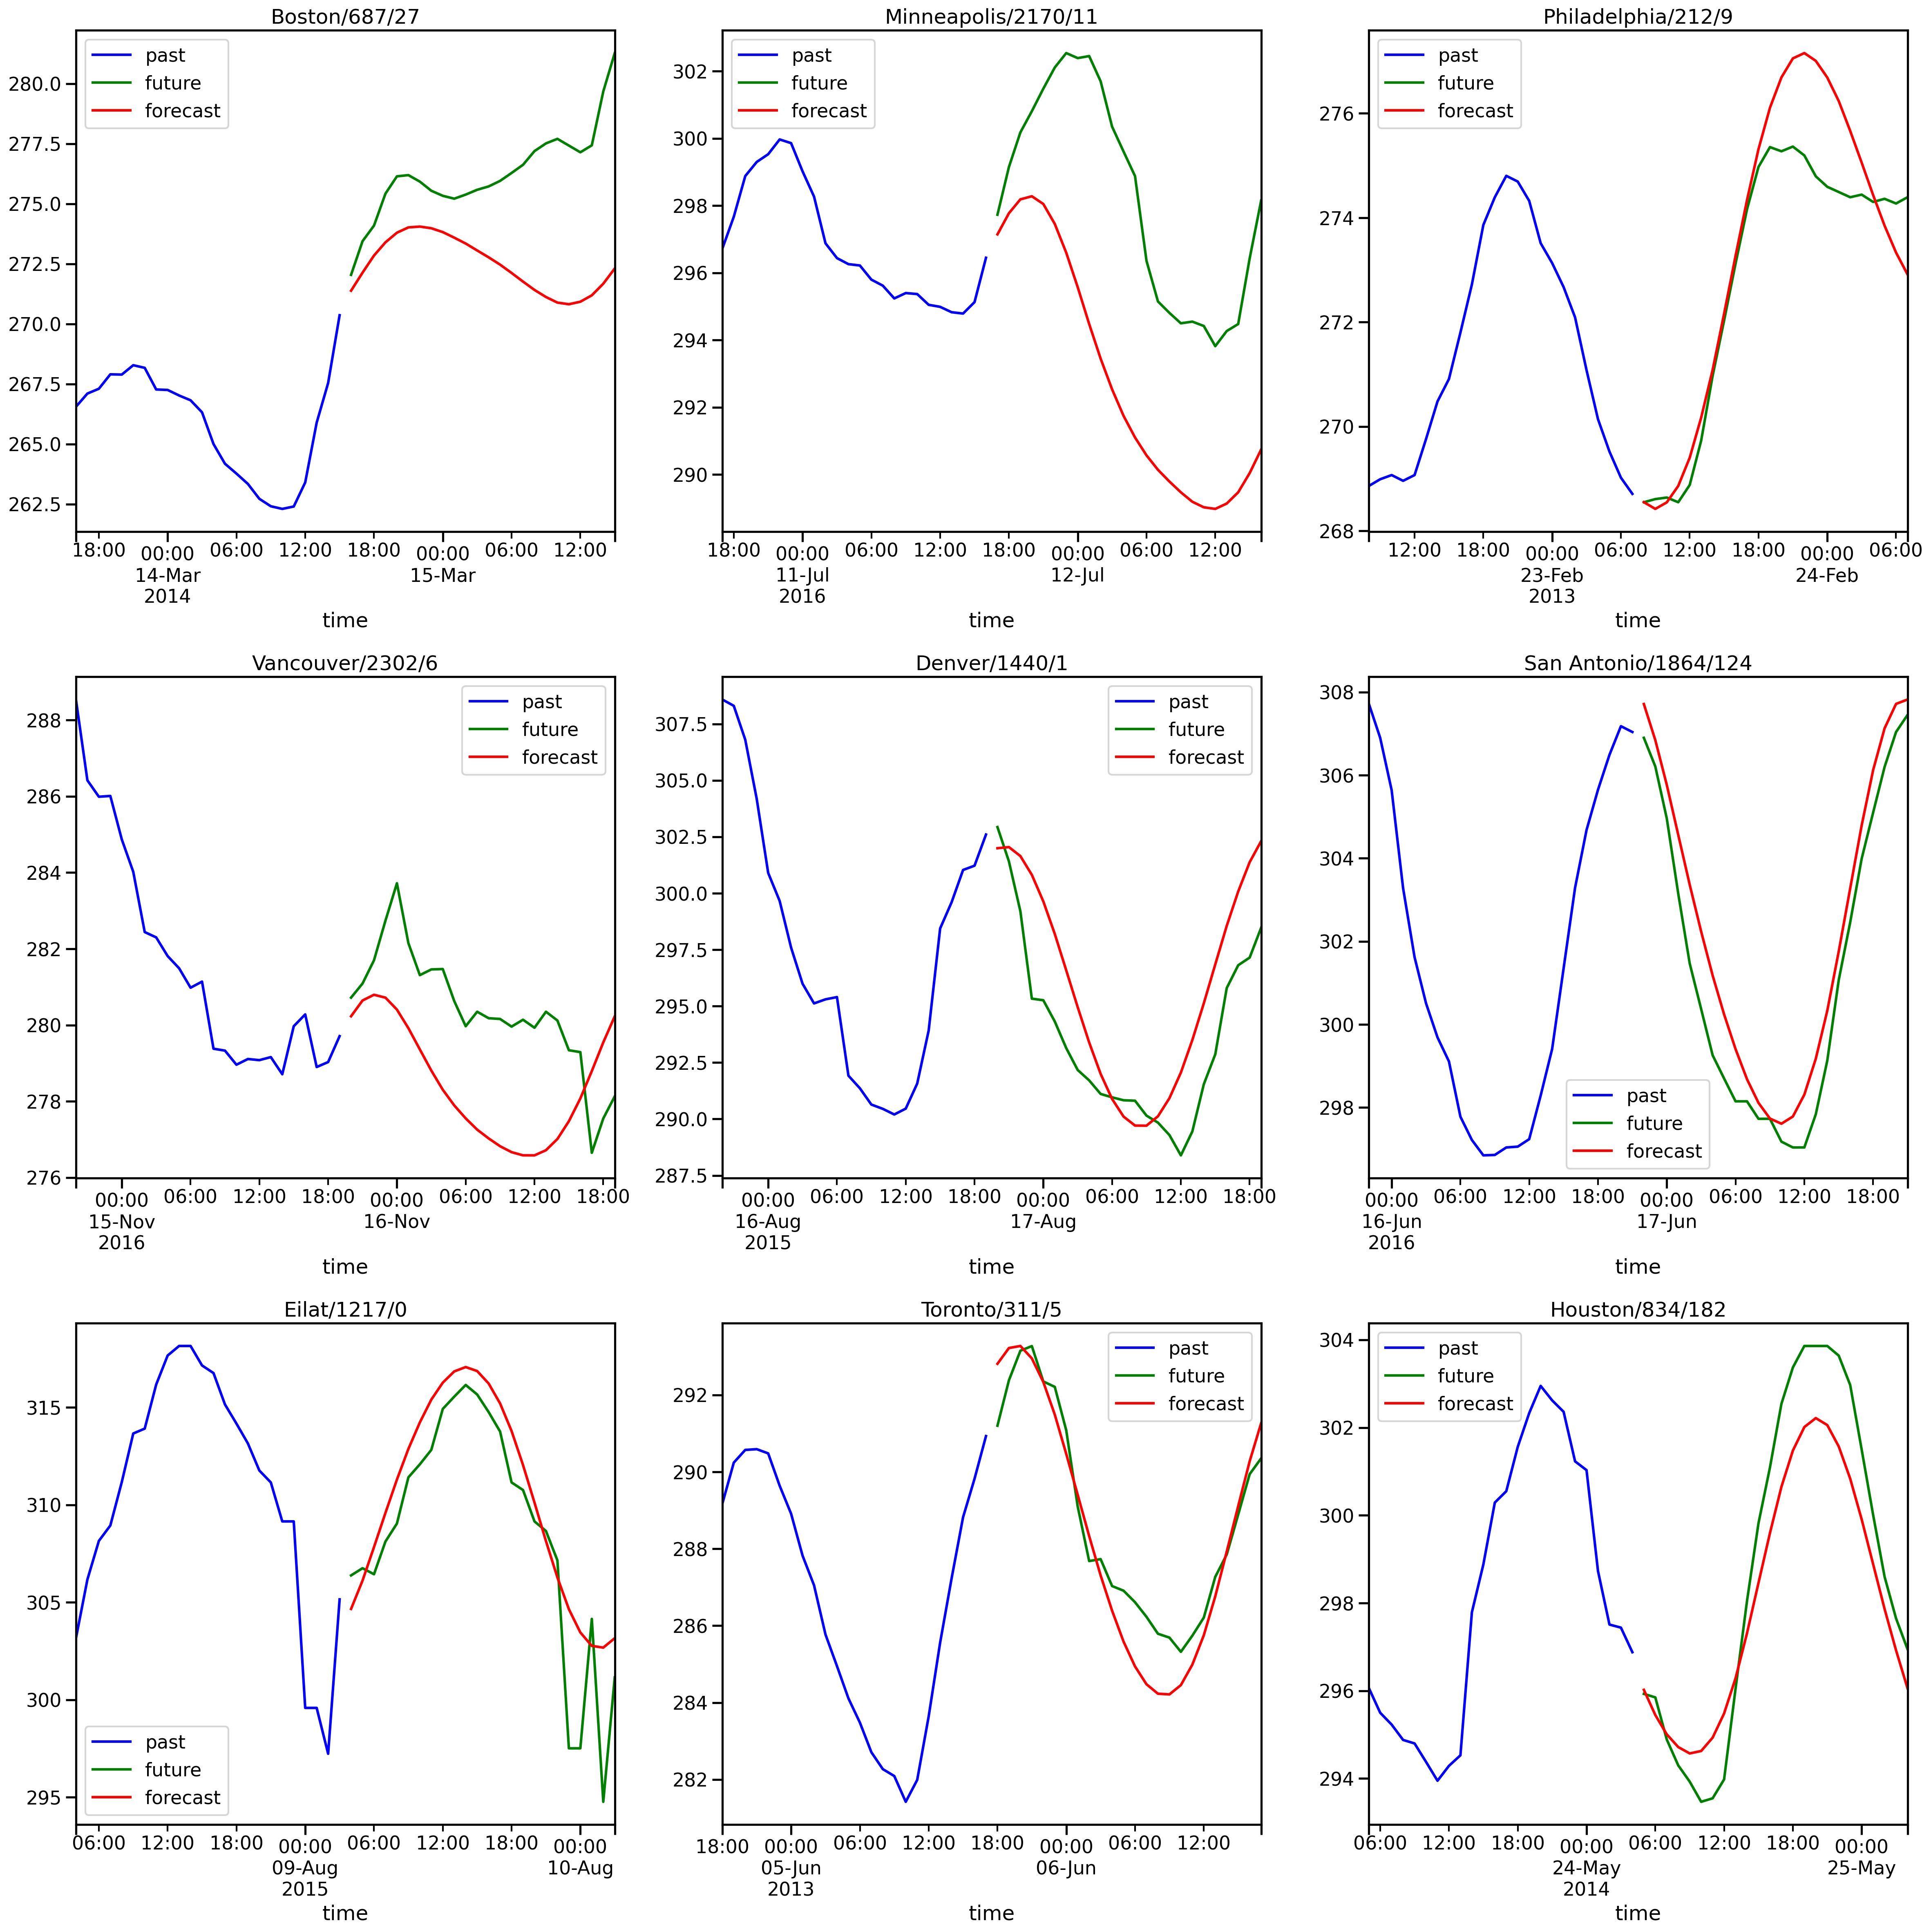

In [26]:
from utils import nd_target_like_panel, plot_random_forecasts

train_y_hat = nd_target_like_panel(train_y, model.predict(train_X_nd))

plot_random_forecasts(
    train_X['temperature'],
    train_y['temperature'],
    train_y_hat.rename(columns={'temperature': 'forecast'})
)

In [27]:
# TODO: save your predictions on the Score segment as a Pandas data frame
# into a variable named score_y_hat.


# Keras model will output an array of shape (2399, 24) for the Score segment,
# however the expected shape of the submitted data frame is (57576, 1).
# 57576 = 2399 (count of samples in Score segment) x 24 (prediction window).
# Use NumPy's reshape() or ravel() functions to achieve this.

# Finally, the data frame needs to have string column names in order to be saved
# as a Parquet file. If you convert a NumPy array to Pandas data frame,
# column names will be integers, but you can replace the columns names.
# There was a similar example of this in the notebook from the first assignment.

### Saving the Score segment predictions as a Pandas data frame
score_y_hat = pd.DataFrame(
    model.predict(score_X_nd).reshape(-1, 1),
    # This is needed to save the file in Parquet format.
    columns=["temperature"]
)

# Expected output: (Index(['temperature'], dtype='object'), (57576, 1))
score_y_hat.columns, score_y_hat.shape

(Index(['temperature'], dtype='object'), (57576, 1))

In [28]:
# Once you are satisfied with your model,
# your need to submit 4 files:
# 1. this notebook and/or any other Python scripts
# 2. Model definition in JSON format
# 3. Model parameters in H5 format
# 4. temperature forecast for the Score segment

import os
model_dir = 'weathernet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.h5")

# Finally, let's save the forecast.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')